In [1]:
import osiris_utils as ou 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Initialize an object of the Simulation class
- The Simulation class takes the `simulation_folder`, this is, the file where the input deck is located.
- It can also take the `species` when we want to use quantities related to a specific species, such as velocities, charge, temperature, etc.

In [2]:
# In this case, since we only want to study the electric field, no species is needed
sim = ou.Simulation(simulation_folder="example_data")

The `Simulation` object acts as a container for the simulation diagnostics, that can be easily accessed from the `Simulation` object using a dictionary-like syntax
In this case, to access the component of the electric field in the z direction, we can use `sim['e3']`. This is a `Diagnostic` object, that loads the data as requested using a data generator, using indices to choose the time step - a lazy loading approach.

In [3]:
# This is a Diagnostic object
sim["e3"]

# This is also a Diagnostic object but initialized directly and not through the Simulation object
e3 = ou.Diagnostic(simulation_folder="example_data")
e3.get_quantity("e3")

print("sim['e3'] class:", sim["e3"].__class__)
print("e3 class:", e3.__class__)

sim['e3'] class: <class 'osiris_utils.data.diagnostic.Diagnostic'>
e3 class: <class 'osiris_utils.data.diagnostic.Diagnostic'>


The data of the diagnostic at a given index can be accessed by indexing the iteration number, e.g. `sim['e3'][0]` will return the electric field in the z direction at the first time step. The data is not stored in memory, but loaded from the file when requested, using a data generator (lazy loading). For example, to plot the electric field in the z direction at the 100th time step, we can use `sim['e3'][100]`, and use the other attributes of the `Diagnostic` object to get the time step, the grid, labels, etc.

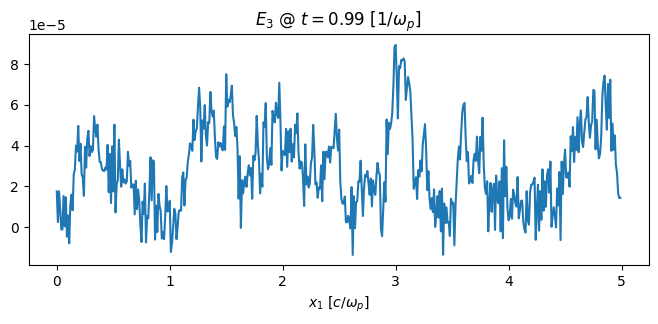

In [4]:
plt.figure(figsize=(8, 3))
plt.plot(sim["e3"].x, sim["e3"][100])
plt.xlabel(sim["e3"].axis[0]["plot_label"])
plt.title(rf"${sim['e3'].label}$ @ $t = {sim['e3'].time(100)[0]:.2f}$ $[{sim['e3'].tunits}]$")
plt.show()

If we want to load the data of the diagnostic at all time steps, we can use the `load_all()` method of the `Diagnostic` object, e.g. `sim['e3'].load_all()` will load the electric field in the z direction at all time steps and store it in memory. This is useful when we want to do the FFT of the data in the time domain, for example. Using the method `unload()` we can clear the data from memory.

In [5]:
sim["e3"].load_all()
print(sim["e3"].data.shape)

e3.load_all()
print(e3.data.shape)

np.isclose(sim["e3"].data, e3.data).all()

sim["e3"].unload()
e3.unload()

Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 749.94it/s]


(254, 500)
Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 989.11it/s] 

(254, 500)
Unloading data from memory.
Unloading data from memory.


Now we are going to use a post process on the simulation data and on the diagnostic. We can think of a `PostProcess` as an operator over the `Diagnostic`'s of the `Simulation`. We define it on the simulation, and to access a post-processed quantity of the simulation, we use the same dictionary-like syntax, e.g. `sim_fft["e3]` to access the FFT of the electric field in the z direction. 

The data is loaded in memory when requested, using a data generator, and can be accessed using the same indexing syntax, e.g. `sim_fft["e3"][0]` to access the FFT of the electric field in the z direction at the first time step. The data can be loaded using the `load_all()` method, and cleared from memory using the `unload()` method.

The post-processing classes inherit from the `PostProcess` class and the `Diagnostic` class, and can be used as a `Diagnostic` object, with the same attributes and methods, ensuring that operations between diagnostics and post-processes are consistent.

Each diagnostic has a version to be applied to `Simulation` objects and another to be applied to `Diagnostic` objects. The first has the name `<name of post-process>`_Simulation, and the second has the name `<name of post-process>_Diagnostic`. For example, the post-process routines for Fast Fourier Transforms are called `FastFourierTransform_Diagnostic` and `FFT_Diagnostic`.

In [6]:
sim_fft = ou.FastFourierTransform_Simulation(sim, (0, 1)) # "operator" FFT applied to Simulation object, axis 0 and 1

e3_fft = ou.FFT_Diagnostic(e3, (0, 1)) # "operator" FFT applied to Diagnostic object, axis 0 and 1

0.0099


In [7]:
sim_fft["e3"][100] # this will only return the kx axis, since we are only requesting the 100th time step of the FFT of e3

e3_fft[100] # this will return the kx and ky axis, since we are only requesting the 100th time step of the FFT of e3

np.isclose(sim_fft["e3"][100], e3_fft[100]).all() # They are the same!

0.0099


np.True_

Since my goal is to plot the dispersion relation, I will need to use `.load_all()` to load all the time steps, and have access to the data in the frequency domain.

In [8]:
sim_fft["e3"].load_all()
e3_fft.load_all()

np.isclose(sim_fft["e3"].data, e3_fft.data).all() # They are the same!

Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 1042.66it/s]
FFT calculation: 100%|██████████| 1.0/1 [00:00<00:00, 257.34it/s]


Loading all data from files. This may take a while.


Loading data: 100%|██████████| 254/254 [00:00<00:00, 877.14it/s]
FFT calculation: 100%|██████████| 1.0/1 [00:00<00:00, 168.20it/s]


np.True_

We can now plot!

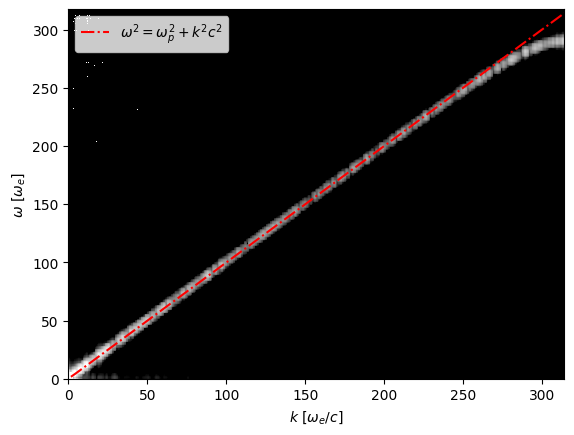

In [9]:
plt.imshow(sim_fft["e3"].data, origin = 'lower', norm=LogNorm(vmin = 1e-7, vmax = 0.01),
           extent = ( -sim_fft["e3"].kmax, sim_fft["e3"].kmax, -sim_fft["e3"].omega_max, sim_fft["e3"].omega_max ),
           aspect = 'auto', cmap = 'gray')

# Plotting the dispersion relation
k = np.linspace(-e3_fft.kmax, e3_fft.kmax, num = 512)
w=np.sqrt(1 + k**2)
plt.plot( k, w, label = r"$\omega^2 = \omega_p^2 + k^2c^2$", color = 'r', ls = '-.' )
plt.xlim(0, e3_fft.kmax)
plt.ylim(0, e3_fft.omega_max)

plt.xlabel(r"$k$ $[\omega_e/c]$")
plt.ylabel(r"$\omega$ $[\omega_e]$")
plt.legend()
plt.show()

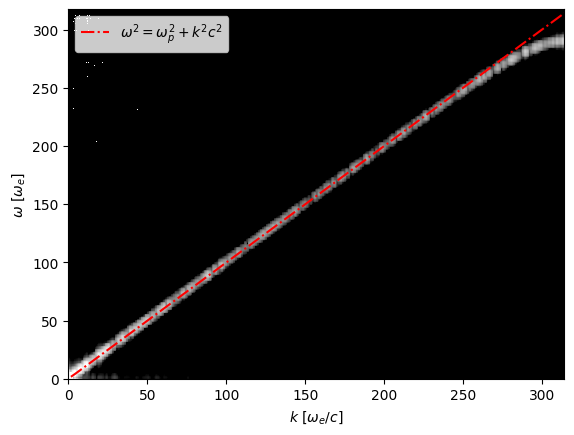

In [10]:
plt.imshow(e3_fft.data, origin = 'lower', norm=LogNorm(vmin = 1e-7, vmax = 0.01),
           extent = ( -e3_fft.kmax, e3_fft.kmax, -e3_fft.omega_max, e3_fft.omega_max ),
           aspect = 'auto', cmap = 'gray')

# Plotting the dispersion relation
k = np.linspace(-e3_fft.kmax, e3_fft.kmax, num = 512)
w=np.sqrt(1 + k**2)
plt.plot( k, w, label = r"$\omega^2 = \omega_p^2 + k^2c^2$", color = 'r', ls = '-.' )
plt.xlim(0, e3_fft.kmax)
plt.ylim(0, e3_fft.omega_max)

plt.xlabel(r"$k$ $[\omega_e/c]$")
plt.ylabel(r"$\omega$ $[\omega_e]$")
plt.legend()
plt.show()